# Intensive lectures at Niigata U. 
## (6-7th July 2023)


# Hands-on 3: Adiabatic state preparation of vacuum in 1+1D transverse Ising model
$$ H= -J\sum_{n=1}^{N-1}Z_n Z_{n+1} -h\sum_{n=1}^N X_n -m\sum_{n=1}^N Z_n  $$
## (with open boundary condition)

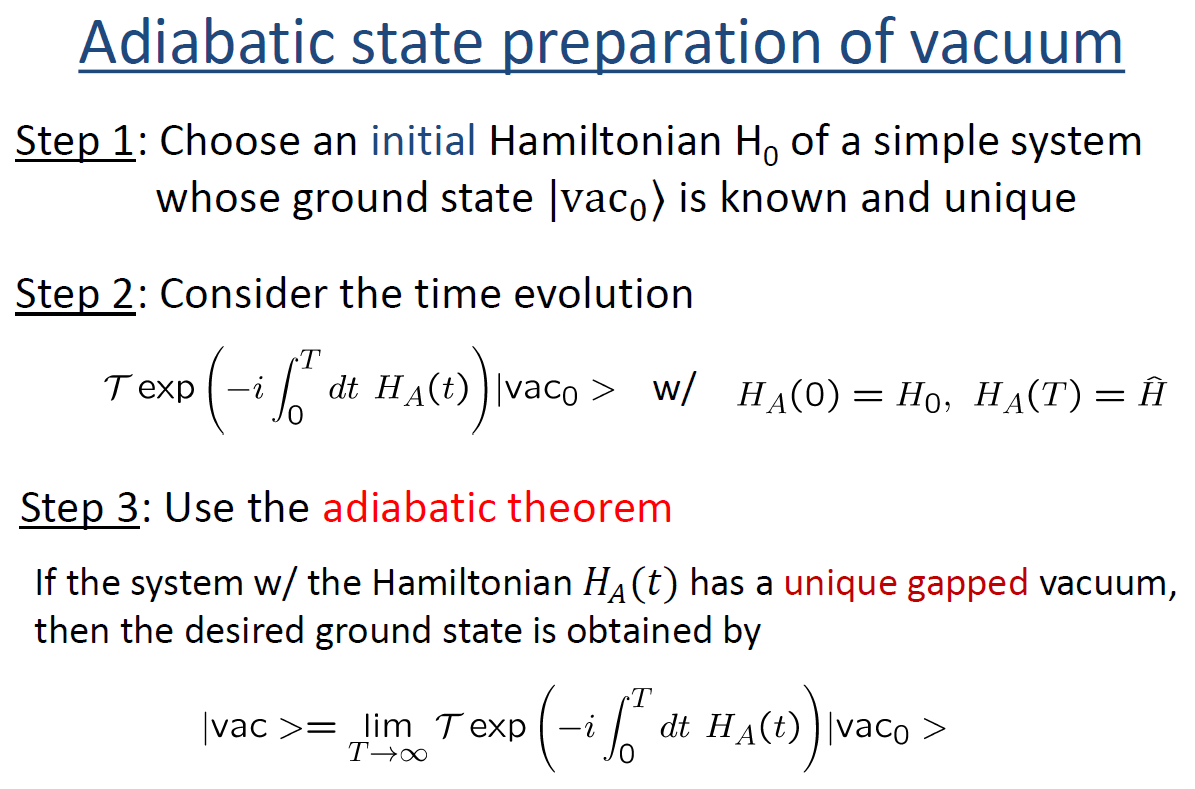

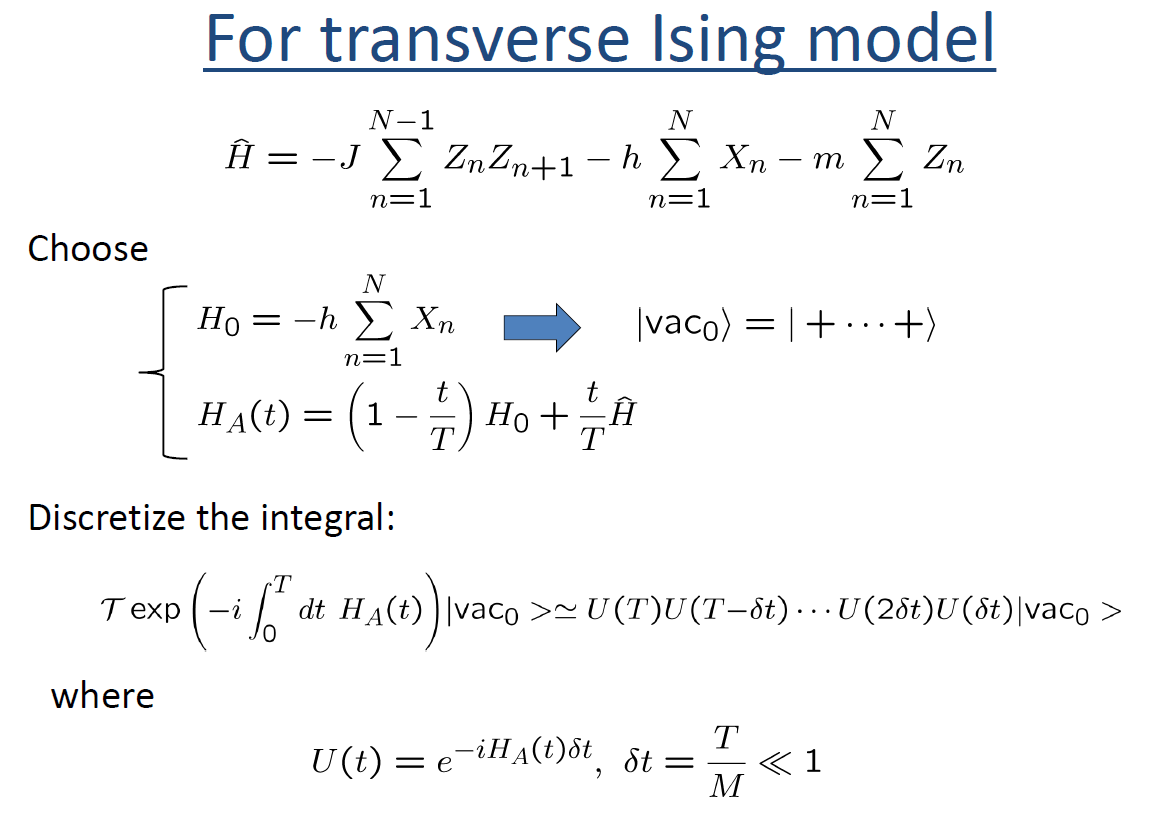

## Explicit form of $H_A (t)$  is
$$ H_A (t) = -\frac{tJ}{T}\sum_{n=1}^{N-1}Z_n Z_{n+1} -h\sum_{n=1}^N X_n -\frac{tm}{T}\sum_{n=1}^N Z_n  $$


###  Import packages

In [1]:
import numpy as np
from qiskit import *
import math

### Fix the parameters 

In [2]:
N=4
J=1.0
h=1.0
m=1.0

## Excercise 1: Draw a quantum circuit for constructing
$$|{\rm vac}_A \rangle
\equiv U(T) U(T-\delta t) \cdots U(2\delta t) U(\delta t) |{\rm vac_0} \rangle \quad {\rm with}\ \delta t=\frac{T}{M}$$
## for $T=1, M=2$ using Trotter decomposition (assuming $\delta t\ll 1$)

### (Note $ \frac{t}{T}  = \frac{(j+1)\delta t}{T} =\frac{j+1}{M}   )$

## Answer

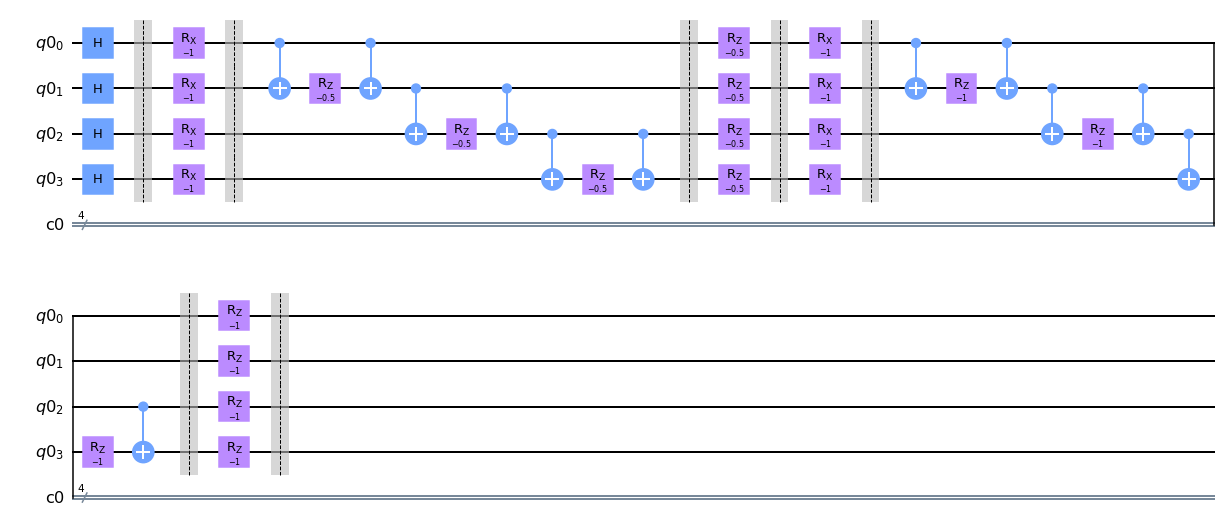

In [5]:
# definition of parameters
T=1.0
M=2
# just for convenience
dt=T/M
#time independent coefficient 
coeffX=-2*h*dt

q = QuantumRegister(N)
c = ClassicalRegister(N)
# circuit for time evolution
qc = QuantumCircuit(q,c)

#Get |vac_0>
for n in range(N):
 qc.h(q[n])
qc.barrier(q)


#time=[]
#prob=[]

### Repeating t}ime evolution
for j in range(M):
# H_X part
 for n in range (N):
  qc.rx(coeffX,q[n])   
 qc.barrier(q)
   
# H_ZZ part
#time dependent coefficient 
 coeffZZ=-2*J*dt*(j+1)/M
 for n in range (N-1):
  qc.cx(q[n],q[n+1])
  qc.rz(coeffZZ,q[n+1])   
  qc.cx(q[n],q[n+1])
 qc.barrier(q)

# H_Z part
#time dependent coefficient 
 coeffZ=-2*m*dt*(j+1)/M
 for n in range (N):
  qc.rz(coeffZ,q[n])   
 qc.barrier(q)


qc.draw(output='mpl')


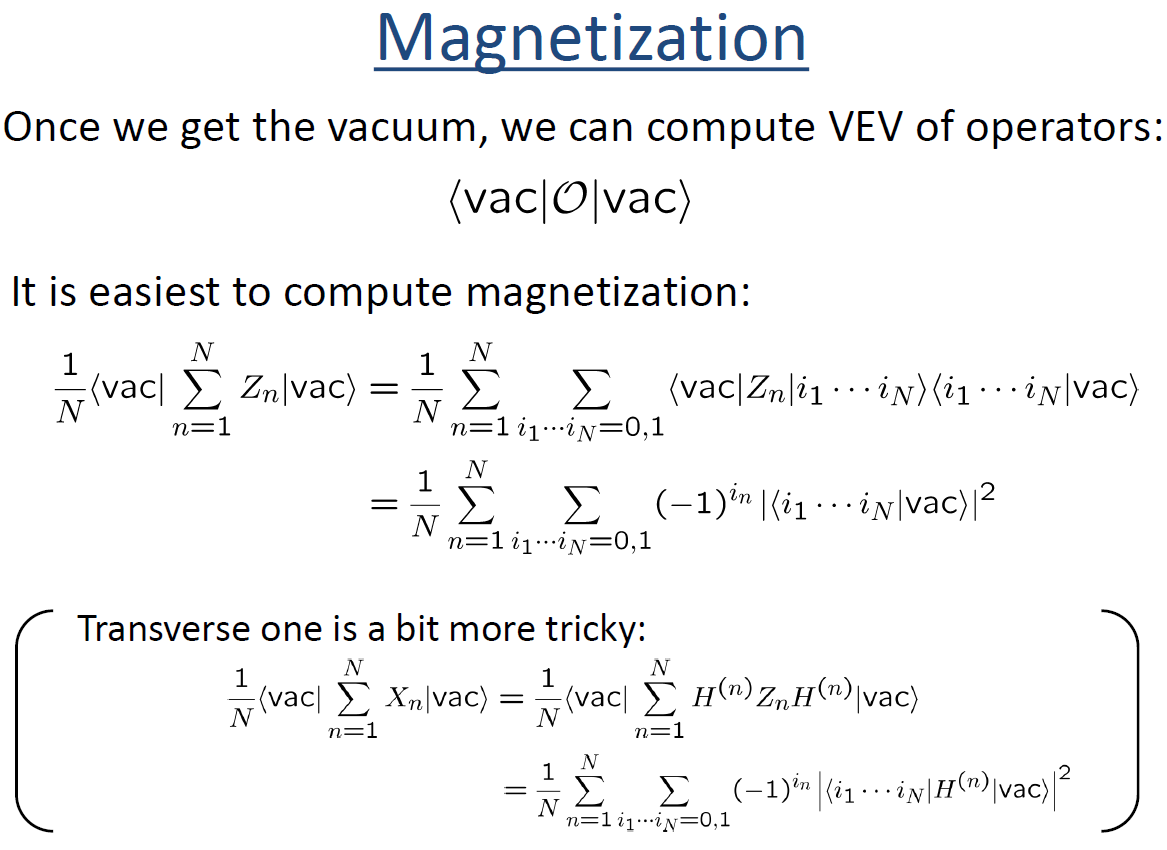

## Excersise 2: Compute expectation value of magnetization under approximate vacuum:
$$ \frac{1}{N}\langle {\rm vac}_A | \sum_{n=1}^N Z_n |{\rm vac}_A \rangle $$
## for $T=100, M=500$ by 100000 shots 
### (result by exact diagonalization: 0.9114425606142261)

## Answer

In [5]:
shot_times=100000
T=100
M=500
# just for convenience
dt=T/M
#time independent coefficient 
coeffX=-2*h*dt


q = QuantumRegister(N)
c = ClassicalRegister(N)
simulator = Aer.get_backend('qasm_simulator')
# circuit for time evolution
qc = QuantumCircuit(q,c)
# circuit for measument
meas = QuantumCircuit(q, c)
meas.measure(q[0:N],c[0:N]) 

#Get |vac_0>
for n in range(N):
 qc.h(q[n])

### Repeating time evolution
for j in range(M):
# H_X part
 for n in range (N):
  qc.rx(coeffX,q[n])   
   
# H_ZZ part
#time dependent coefficient 
 coeffZZ=-2*J*dt*(j+1)/M
 for n in range (N-1):
  qc.cx(q[n],q[n+1])
  qc.rz(coeffZZ,q[n+1])   
  qc.cx(q[n],q[n+1])

# H_Z part
#time dependent coefficient 
 coeffZ=-2*m*dt*(j+1)/M
 for n in range (N):
  qc.rz(coeffZ,q[n])   

## Measurement
total=qc.compose(meas)
#total=qc +meas
job = execute(total, simulator, shots=shot_times)
result = job.result()
counts = result.get_counts(total)

#print(counts)
## Compute magnetization
ave=0
for state, count in counts.items():
  obs=0
  for k in range(N):
    obs += (-1)**int(state[k]) 
  ave += obs*count
mag=ave/(N*shot_times)

print(counts)
print(mag)

{'1000': 5198, '0000': 82596, '0110': 136, '0001': 5107, '0010': 2701, '1101': 22, '0100': 2783, '0011': 384, '1100': 341, '1001': 331, '1010': 159, '0101': 177, '0111': 18, '1110': 17, '1011': 25, '1111': 5}
0.904445


## Result by exact diagonalization (you don't need to run and understand the code):

In [7]:
#####get result by exact diagonalization for checking
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.tools.measurements import obs_vs_time
##
czzq=-J
czq=-m
cxq=-h

basis = spin_basis_1d(N) # any magnetisation sector
# basis = spin_basis_1d(N,Nup=N//2) # zero magnetisation sector

Hzz=[[ czzq,k,k+1] for k in range(N-1) ]
Hz=[[czq,i] for i in range(N)]
Hx=[[cxq,i] for i in range(N)]
    
# static and dynamic lists
static = [["x",Hx],["zz",Hzz],["z",Hz]] 
dynamic=[]
# Hfull = hamiltonian(static,dynamic,basis=basis,dtype=np.float64)
Hfull = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False)

# calculate full eigensystem
E,V=Hfull.eigh()

    
chiral=[[1/N,i] for i in range(N)]
static2=[["z",chiral]]
chiralop = hamiltonian(static2,dynamic,basis=basis,dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False)

meas = obs_vs_time(V[:,0],0,{"condensate":chiralop})
condensate=meas["condensate"]
 
print(condensate)

0.9114425606142263


## How it approaches the correct value

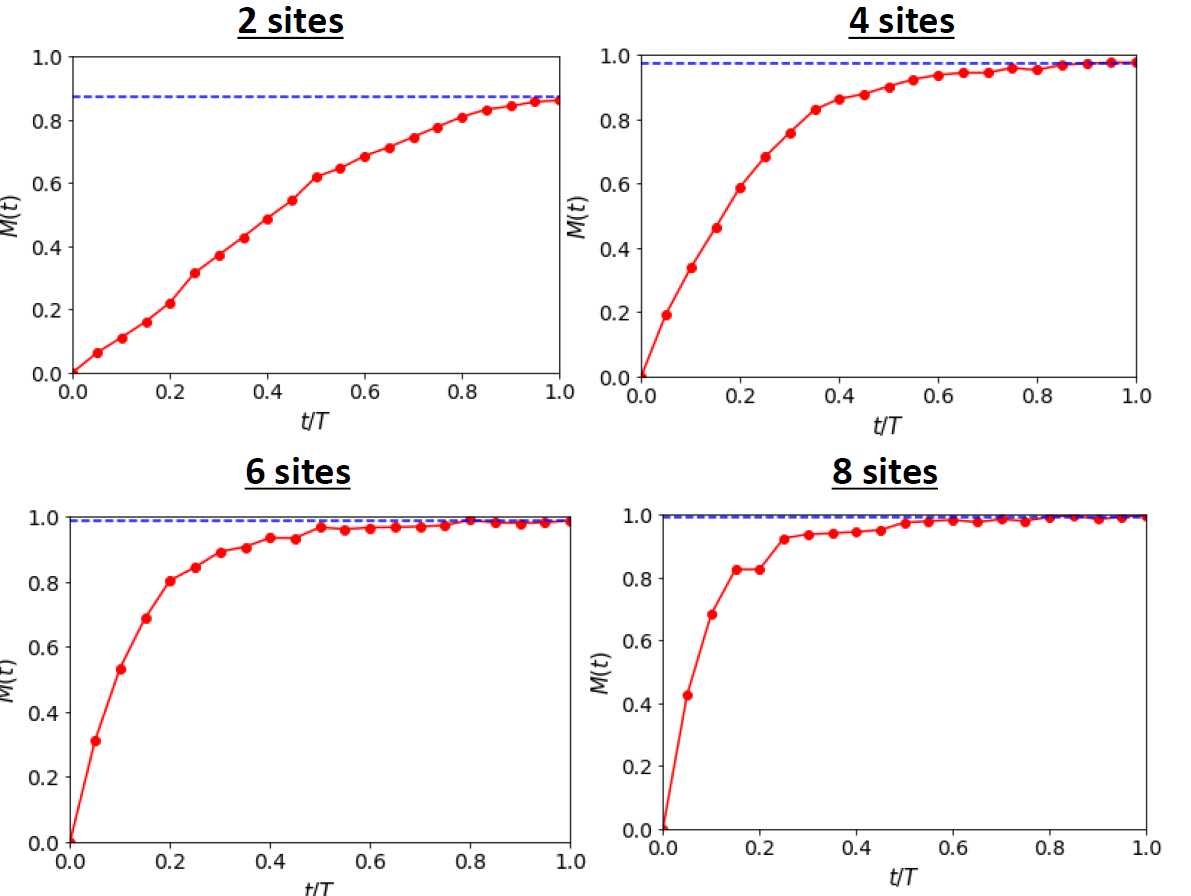

## Excersise 3: Compute expectation value of transverse magnetization under approximate vacuum:
$$ \frac{1}{N}\langle {\rm vac}_A | \sum_{n=1}^N X_n |{\rm vac}_A \rangle $$
## for $T=100, M=500$ by 100000 shots 
## (result of exact diagonalization: 0.4029028961384725)

## Answers

In [8]:
shot_times=100000
T=100
M=500
# just for convenience
dt=T/M
#time independent coefficient 
coeffX=-2*h*dt


q = QuantumRegister(N)
c = ClassicalRegister(N)
simulator = Aer.get_backend('qasm_simulator')
# circuit for time evolution
qc = QuantumCircuit(q,c)
# circuit for measument
meas = QuantumCircuit(q, c)
meas.measure(q[0:N],c[0:N]) 

#Get |vac_0>
for n in range(N):
 qc.h(q[n])

### Repeating t}ime evolution
for j in range(M):
# H_X part
 for n in range (N):
  qc.rx(coeffX,q[n])   
   
# H_ZZ part
#time dependent coefficient 
 coeffZZ=-2*J*dt*(j+1)/M
 for n in range (N-1):
  qc.cx(q[n],q[n+1])
  qc.rz(coeffZZ,q[n+1])   
  qc.cx(q[n],q[n+1])

# H_Z part
#time dependent coefficient 
 coeffZ=-2*m*dt*(j+1)/M
 for n in range (N):
  qc.rz(coeffZ,q[n])   

# for measuring <X>
for n in range(N):
 qc.h(q[n])
## Measurement
total=qc.compose(meas)
#total=qc +meas
job = execute(total, simulator, shots=shot_times)
result = job.result()
counts = result.get_counts(total)

## Compute magnetization
ave=0
for state, count in counts.items():
  obs=0
  for k in range(N):
    obs += (-1)**int(state[k]) 
  ave += obs*count
mag=ave/(N*shot_times)


print(mag)

0.37057
